In [1]:
from plotting_utils import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import rankdata
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

# Complete datasets

## Statistical test
Conduct Friedman test. If null hypothesis rejected, follow by Bonferroni-Dunn post-hoc test.

In [2]:
# Loading dataset
deoxy_perf_df = pd.read_excel("performance_excels/deoxy/fp_base_False.xlsx")
informer_perf_df = pd.read_excel("performance_excels/informer/fp_catalyst_ratio_False.xlsx")
amine_perf_df = pd.read_excel("performance_excels/natureHTE/fp_amine_None.xlsx")
amide_perf_df = pd.read_excel("performance_excels/natureHTE/fp_amide_None.xlsx")
sulfon_perf_df = pd.read_excel("performance_excels/natureHTE/fp_sulfonamide_None.xlsx")

In [3]:
models = deoxy_perf_df["model"].unique().tolist()
avg_perf_dict = {
    "model":[],
    "dataset":[],
    "average reciprocal rank":[],
    "average kendall tau":[],
}
for i in range(6) :
    deoxy_sub_df = deoxy_perf_df.iloc[320*i:320*(i+1)]
    for model in models :
        avg_perf_dict["model"].append(model)
        avg_perf_dict["dataset"].append(f"Deoxy-sulfonyl fluoride {i}")
        avg_perf_dict["average reciprocal rank"].append(
            deoxy_sub_df[deoxy_sub_df["model"]==model]["reciprocal_rank"].mean()
        )
        avg_perf_dict["average kendall tau"].append(
            deoxy_sub_df[deoxy_sub_df["model"]==model]["kendall_tau"].mean()
        )
for i in range(2) :
    informer_sub_df = informer_perf_df.iloc[110*i:110*(i+1)]
    for model in models :
        avg_perf_dict["model"].append(model)
        avg_perf_dict["dataset"].append(f"Informer-catalyst ratio {i}")
        avg_perf_dict["average reciprocal rank"].append(
            informer_sub_df[informer_sub_df["model"]==model]["reciprocal_rank"].mean()
        )
        avg_perf_dict["average kendall tau"].append(
            informer_sub_df[informer_sub_df["model"]==model]["kendall_tau"].mean()
        )
nature_HTE_perf_dfs = [amine_perf_df, amide_perf_df, sulfon_perf_df]
nature_HTE_names = ["amine", "amide", "sulfonamide"]
for model in models :
    for dataset_name, perf_df in zip(nature_HTE_names, nature_HTE_perf_dfs) :
        avg_perf_dict["model"].append(model)
        avg_perf_dict["dataset"].append(f"Nature-{dataset_name}")
        avg_perf_dict["average reciprocal rank"].append(
            perf_df[perf_df["model"]==model]["reciprocal_rank"].mean()
        )
        avg_perf_dict["average kendall tau"].append(
            perf_df[perf_df["model"]==model]["kendall_tau"].mean()
        )
avg_perf_df = pd.DataFrame(avg_perf_dict)

In [4]:
rr_table = pd.pivot_table(avg_perf_df, values="average reciprocal rank", index="dataset", columns="model")
kt_table = pd.pivot_table(avg_perf_df, values="average kendall tau", index="dataset", columns="model")

kt_table.to_excel("performance_excels/complete_datasets_average_performances.xlsx", sheet_name="kendall_tau")
with pd.ExcelWriter("performance_excels/complete_datasets_average_performances.xlsx", mode="a") as writer :
    rr_table.to_excel(writer, sheet_name="reciprocal_rank")

In [5]:
rr_rank_by_dataset = rr_table.shape[1] + 1 - rankdata(rr_table, axis=1)
kt_rank_by_dataset = kt_table.shape[1] + 1 - rankdata(kt_table, axis=1)

rr_friedman_results = friedmanchisquare(
    *(rr_rank_by_dataset[:, x] for x in range(len(models)))
)
kt_friedman_results = friedmanchisquare(
    *(kt_rank_by_dataset[:, x] for x in range(len(models)))
)
print(rr_friedman_results)
print(kt_friedman_results)

FriedmanchisquareResult(statistic=14.082674772036494, pvalue=0.11941456894820969)
FriedmanchisquareResult(statistic=13.949451887941587, pvalue=0.12413471777638242)


In [6]:
avg_rr_rank = np.mean(rr_rank_by_dataset, axis=0)
avg_kt_rank = np.mean(kt_rank_by_dataset, axis=0)
print(sorted(models))
print(avg_rr_rank)
print(avg_kt_rank)

['Baseline', 'IBM', 'IBPL', 'KNN', 'LR', 'LRRF', 'LRT', 'RFC', 'RFR', 'RPC']
[7.6  5.45 6.05 5.35 6.05 4.3  6.25 3.25 5.95 4.75]
[5.4  4.75 4.1  5.65 7.9  4.1  6.05 5.05 5.15 6.85]


In [7]:
# results from label ranking algorithms undergoing CV
rr_CV = pd.read_excel("performance_excels/complete_datasets_CV.xlsx", sheet_name="reciprocal_rank", index_col="dataset")
rr_rank_by_dataset_CV = rr_CV.shape[1] + 1 - rankdata(rr_CV, axis=1)
rr_friedman_results_CV = friedmanchisquare(
    *(rr_rank_by_dataset_CV[:, x] for x in range(len(models)))
)
print(rr_friedman_results_CV)

FriedmanchisquareResult(statistic=15.758201701093588, pvalue=0.07210590754298651)


In [8]:
print(sorted(models))
print(np.mean(rr_rank_by_dataset_CV, axis=0))
print(np.mean(rr_rank_by_dataset, axis=0))


['Baseline', 'IBM', 'IBPL', 'KNN', 'LR', 'LRRF', 'LRT', 'RFC', 'RFR', 'RPC']
[7.5  6.5  6.3  4.95 5.6  4.35 6.4  3.1  5.55 4.75]
[7.6  5.45 6.05 5.35 6.05 4.3  6.25 3.25 5.95 4.75]


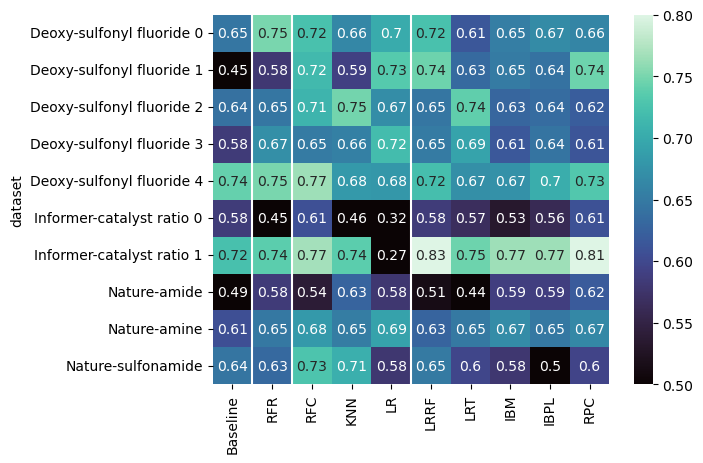

In [9]:
fig, ax = plt.subplots()
ordered_cols = ["Baseline", "RFR", "RFC", "KNN", "LR", "LRRF", "LRT", "IBM", "IBPL", "RPC"]
ordered_rr_CV = rr_CV[ordered_cols]
sns.heatmap(ordered_rr_CV, vmin=0.5, vmax=0.8, cmap="mako", annot=True) #
ax.axvline(1,0,1, c="white")
ax.axvline(2,0,1, c="white")
ax.axvline(5,0,1, c="white")

<Figure size 640x480 with 0 Axes>

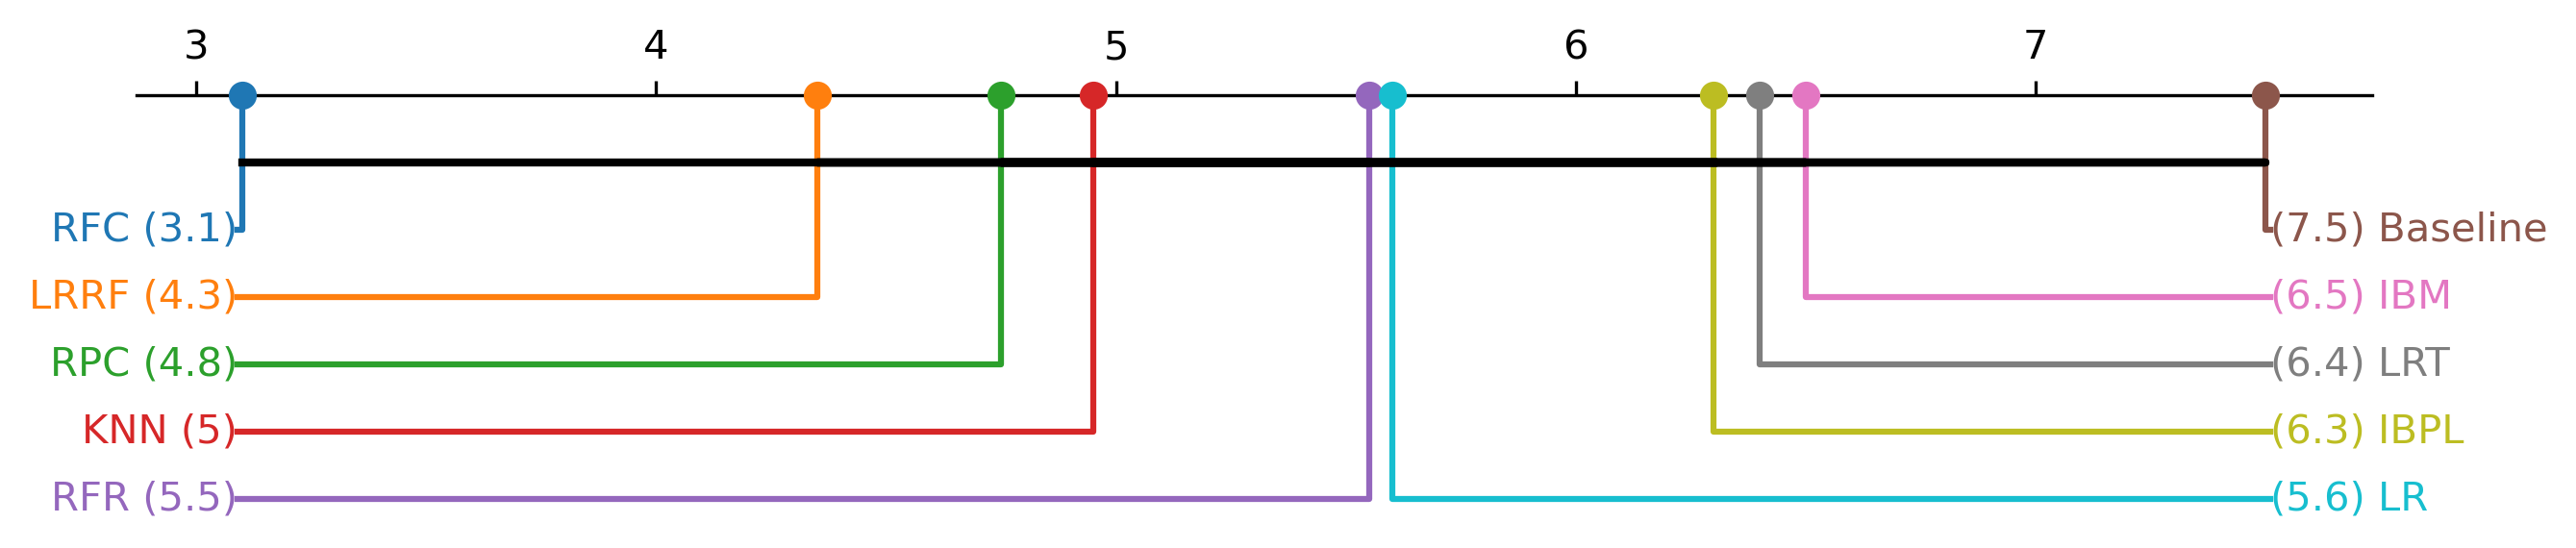

In [10]:
bonferroni_dunn_test_results = sp.posthoc_dunn(
    rr_CV.unstack().reset_index(name="average rank"), 
    val_col="average rank",
    group_col="level_0",
    p_adjust="bonferroni"
)
nemenyi_results = sp.posthoc_nemenyi_friedman(
    rr_CV.unstack().reset_index(name="average rank"),
    y_col="average rank",
    block_col="dataset",
    group_col="level_0",
    melted=True
)
rr_rank_CV_dict = {x:r for x, r in zip(sorted(models), np.mean(rr_rank_by_dataset_CV, axis=0))}

plt.set_cmap("viridis")
plt.figure(figsize=(10,2), dpi=300)
critical_difference_diagram(rr_rank_CV_dict, bonferroni_dunn_test_results)
plt.show()

# Partial datasets

### Statistical analysis collecting all results

#### Missing 25%

In [11]:
quarter_missing_rr = pd.read_excel("performance_excels/25percent_missing_average_performances.xlsx", index_col="dataset", sheet_name="reciprocal_rank")

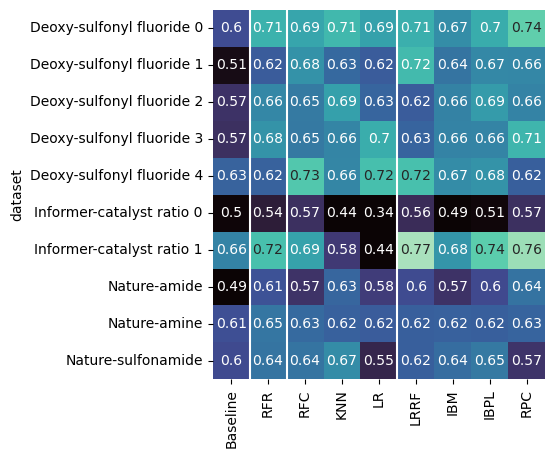

In [12]:
fig, ax = plt.subplots()
ordered_cols = ["Baseline", "RFR", "RFC", "KNN", "LR", "LRRF", "IBM", "IBPL", "RPC"]
ordered_rr_quarter_missing = quarter_missing_rr[ordered_cols]
sns.heatmap(ordered_rr_quarter_missing, vmin=0.5, vmax=0.8, cmap="mako", annot=True, cbar=False, square=True) #
ax.axvline(1,0,1, c="white")
ax.axvline(2,0,1, c="white")
ax.axvline(5,0,1, c="white")

<Figure size 640x480 with 0 Axes>

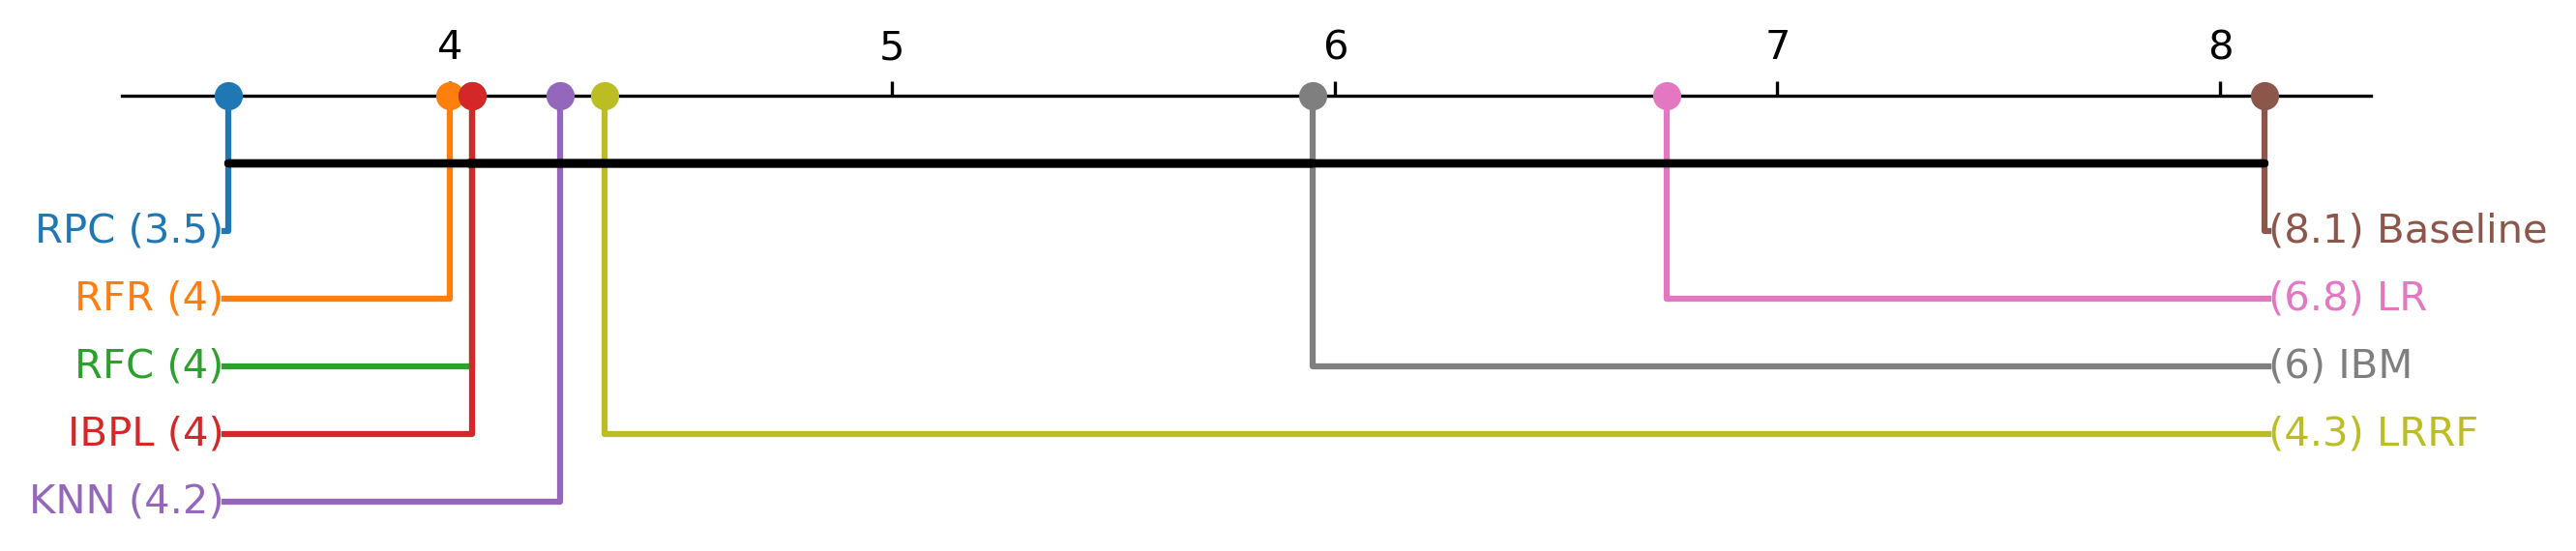

In [13]:
bonferroni_dunn_test_results = sp.posthoc_dunn(
    quarter_missing_rr.unstack().reset_index(name="average rank"), 
    val_col="average rank",
    group_col="level_0",
    p_adjust="bonferroni"
)
nemenyi_results = sp.posthoc_nemenyi_friedman(
    quarter_missing_rr.unstack().reset_index(name="average rank"),
    y_col="average rank",
    block_col="dataset",
    group_col="level_0",
    melted=True
)
average_rank_by_dataset_quarter_missing = 10 - rankdata(quarter_missing_rr.to_numpy(), axis=1)
rr_rank_CV_dict = {x:r for x, r in zip(quarter_missing_rr.columns.tolist(), np.mean(average_rank_by_dataset_quarter_missing, axis=0))}

plt.set_cmap("viridis")
plt.figure(figsize=(10,2), dpi=300)
critical_difference_diagram(rr_rank_CV_dict, bonferroni_dunn_test_results)
plt.show()

#### 50% removed

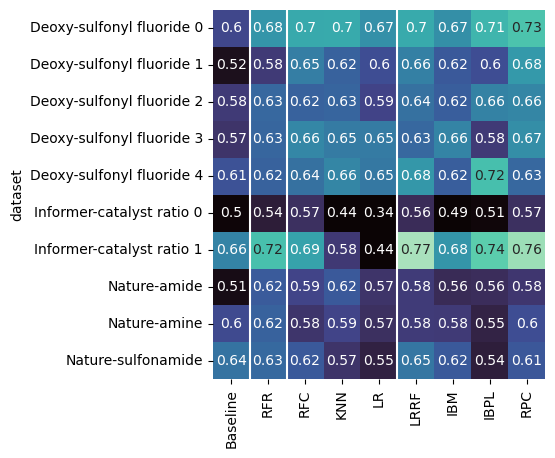

In [14]:
half_missing_rr = pd.read_excel("performance_excels/50percent_missing_average_performances.xlsx", index_col="dataset", sheet_name="reciprocal_rank")

fig, ax = plt.subplots()
ordered_cols = ["Baseline", "RFR", "RFC", "KNN", "LR", "LRRF", "IBM", "IBPL", "RPC"]
ordered_rr_half_missing = half_missing_rr[ordered_cols]
sns.heatmap(ordered_rr_half_missing, vmin=0.5, vmax=0.8, cmap="mako", annot=True, cbar=False, square=True) #
ax.axvline(1,0,1, c="white")
ax.axvline(2,0,1, c="white")
ax.axvline(5,0,1, c="white")

<Figure size 640x480 with 0 Axes>

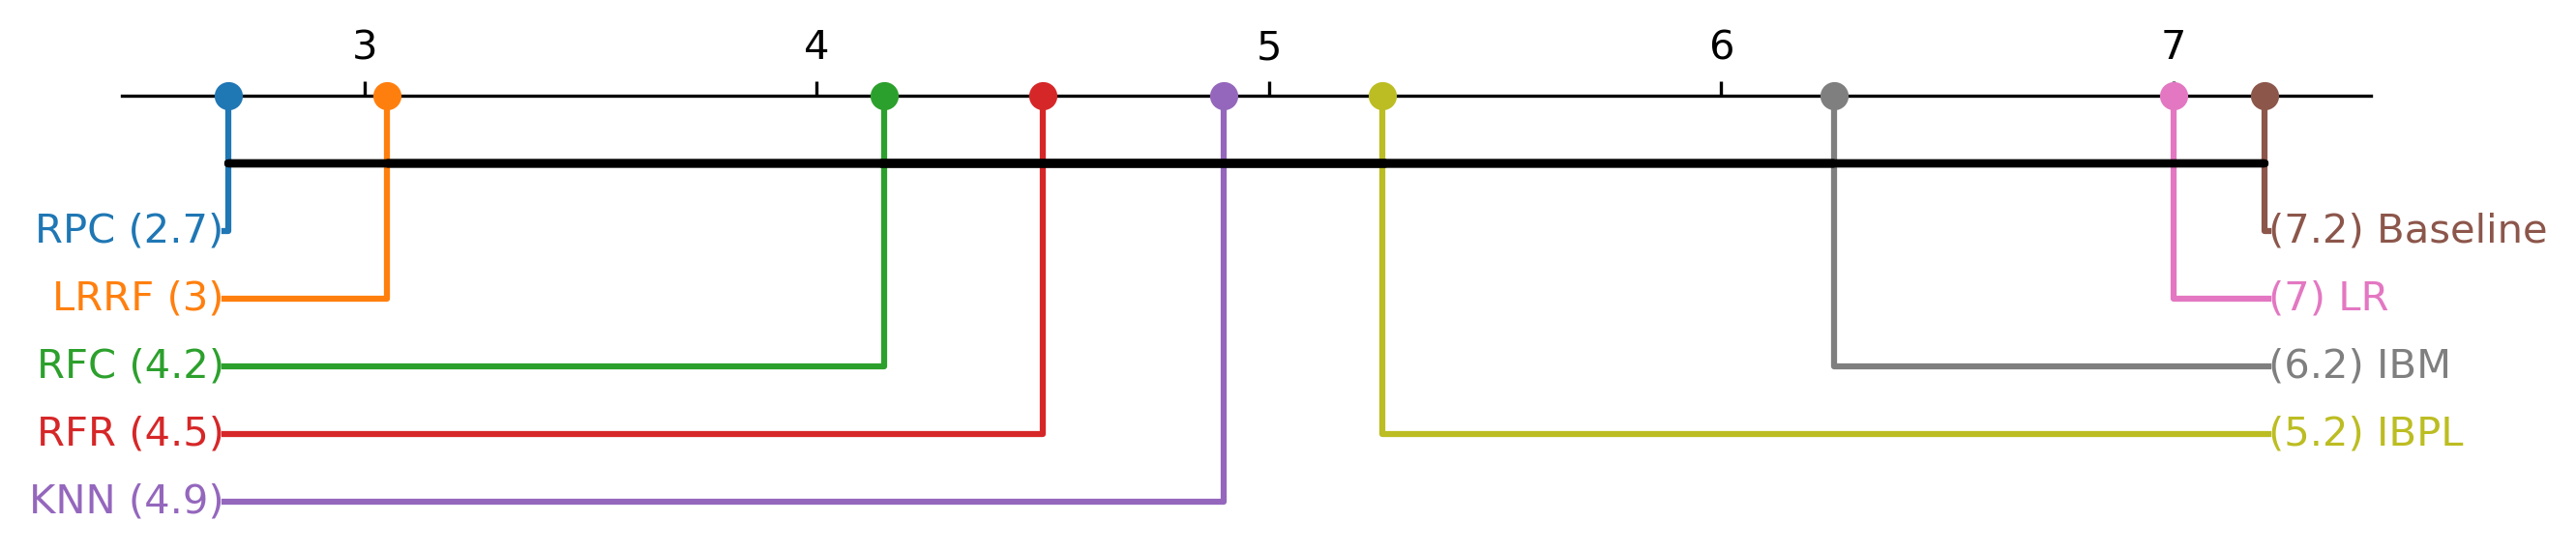

In [15]:
bonferroni_dunn_test_results = sp.posthoc_dunn(
    half_missing_rr.unstack().reset_index(name="average rank"), 
    val_col="average rank",
    group_col="level_0",
    p_adjust="bonferroni"
)
nemenyi_results = sp.posthoc_nemenyi_friedman(
    half_missing_rr.unstack().reset_index(name="average rank"),
    y_col="average rank",
    block_col="dataset",
    group_col="level_0",
    melted=True
)
average_rank_by_dataset_half_missing = 10 - rankdata(half_missing_rr.to_numpy(), axis=1)
rr_rank_CV_dict = {x:r for x, r in zip(half_missing_rr.columns.tolist(), np.mean(average_rank_by_dataset_half_missing, axis=0))}

plt.set_cmap("viridis")
plt.figure(figsize=(10,2), dpi=300)
critical_difference_diagram(rr_rank_CV_dict, bonferroni_dunn_test_results)
plt.show()

#### Trendline

In [32]:
full_df.reset_index()

,dataset,Baseline,IBM,IBPL,KNN,LR,LRRF,LRT,RFC,RFR,RPC,Missing Portion
0,Deoxy-sulfonyl fluoride 0,0.645833,0.654,0.667,0.664062,0.700521,0.724,0.614583,0.723958,0.750000,0.661,0
1,Deoxy-sulfonyl fluoride 1,0.453125,0.651,0.641,0.591146,0.734375,0.745,0.632812,0.716146,0.580729,0.745,0
2,Deoxy-sulfonyl fluoride 2,0.640625,0.630,0.635,0.747396,0.669271,0.646,0.739583,0.710938,0.645833,0.620,0
3,Deoxy-sulfonyl fluoride 3,0.583333,0.615,0.643,0.656250,0.718750,0.651,0.692708,0.651042,0.671875,0.612,0
4,Deoxy-sulfonyl fluoride 4,0.742188,0.674,0.703,0.682292,0.679688,0.721,0.671875,0.765625,0.750000,0.732,0
5,Informer-catalyst ratio 0,0.584848,0.532,0.560,0.460606,0.320846,0.585,0.566667,0.607576,0.447222,0.608,0
6,Informer-catalyst ratio 1,0.722727,0.766,0.766,0.737374,0.272406,0.827,0.745455,0.767355,0.737374,0.812,0
7,Nature-amide,0.491228,0.588,0.588,0.627193,0.578947,0.513,0.438596,0.539474,0.583333,0.618,0
8,Nature-amine,0.606481,0.668,0.647,0.652778,0.691358,0.627,0.648148,0.682099,0.646605,0.665,0
9,Nature-sulfonamide,0.644737,0.579,0.500,0.706140,0.578947,0.649,0.596491,0.728070,0.631579,0.596,0


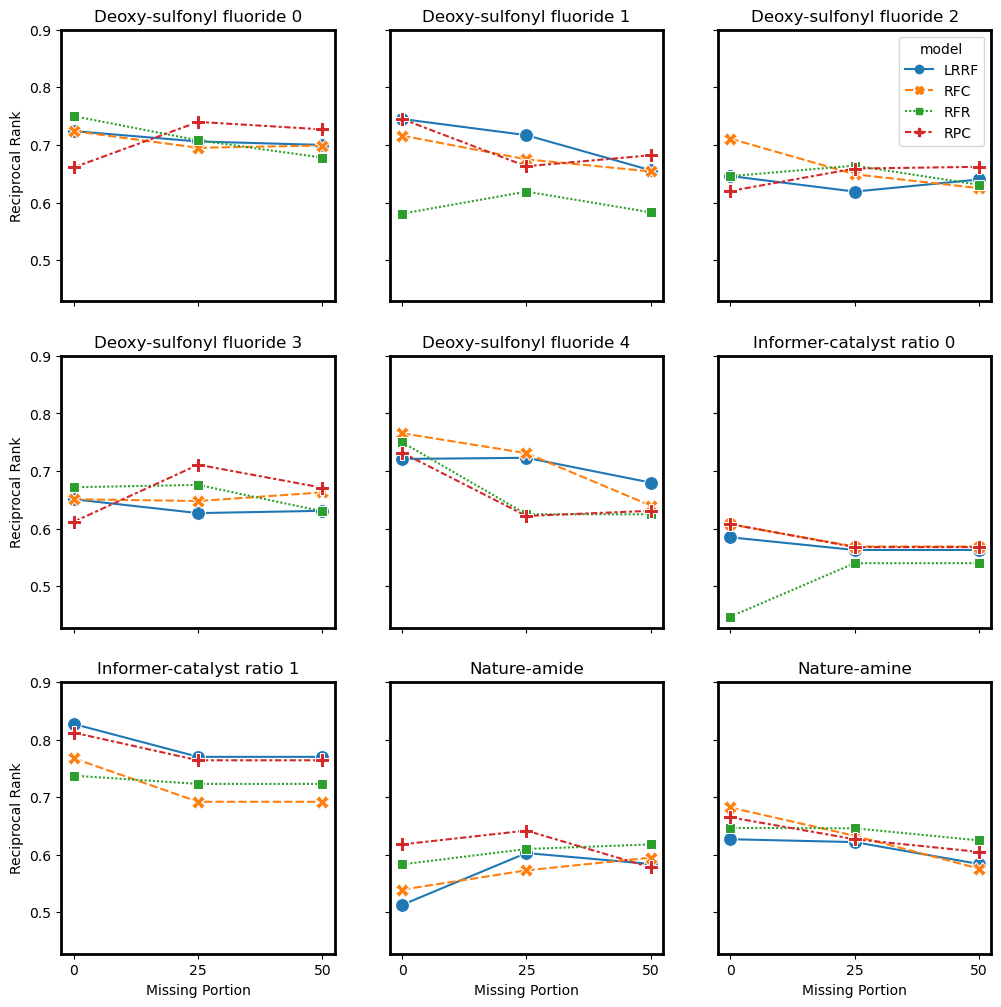

In [50]:
# rr_CV, quarter_missing_rr, half_missing_rr
full_df = pd.concat([rr_CV, quarter_missing_rr, half_missing_rr])
full_df["Missing Portion"] = [0]*rr_CV.shape[0] + [25]*quarter_missing_rr.shape[0] + [50] * half_missing_rr.shape[0]
df_for_trend_figure = pd.melt(full_df.reset_index(), var_name="model", value_vars=full_df.columns[1:-1], value_name="Reciprocal Rank", id_vars=["Missing Portion", "dataset"])

# datasets_to_plot = ["Deoxy-sulfonyl fluoride 2", "Nature-sulfonamide", "Informer-catalyst ratio 1"]

fig, ax = plt.subplots(ncols=3, nrows=3, sharex=True, sharey=True, figsize=(12,12))
for i, dataset_to_plot in enumerate(df_for_trend_figure["dataset"].unique()[:-1]) :
    row = i // 3
    col = i % 3
    sns.lineplot(
        df_for_trend_figure[
            (df_for_trend_figure["model"].isin(["RFR","RFC","LRRF","RPC"])) &\
            (df_for_trend_figure["dataset"]==dataset_to_plot)
        ], 
        x="Missing Portion", y="Reciprocal Rank",
        hue="model", style="model", ax=ax[row, col], markers=True,
        markersize=10
    )
    ax[row, col].set_xticks([0,25,50])
    ax[row, col].set_yticks([0.5+0.1*x for x in range(5)])
    if row == 2 :
        ax[row, col].set_xticklabels([0,25,50])
    if col == 0 :
        ax[row, col].set_yticklabels([0.5+0.1*x for x in range(5)])
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[row, col].spines[axis].set_linewidth(2)
    if row == 0 and col == 2 :
        pass
    else :
        ax[row, col].get_legend().remove()
    ax[row, col].set_title(dataset_to_plot)

## Deoxy dataset analysis

In [23]:
base1_dict = prep_performance_by_model_dict("performance_excels/deoxy/fp_base_False_rem1rxns.xlsx")
base2_dict = prep_performance_by_model_dict("performance_excels/deoxy/fp_base_False_rem2rxns.xlsx")

In [25]:
base_dicts = [{}, {}, {}, {}, {}]
for k, v in base1_dict.items():
    for i in range(5) :
        base_dicts[i].update({
            k:v.iloc[320*i:320*(i+1),:]
        })

for i in range(5):
    print(i)
    for k, v in base_dicts[i].items():
        print(k)
        # print(round(v["regret"].mean(), 1))
        print(round(v["reciprocal_rank"].mean(), 3))
    print("---------------------------")


0
RFR
0.708
Baseline
0.604
RPC
0.74
LRRF
0.706
RFC
0.695
LR
0.69
KNN
0.715
---------------------------
1
RFR
0.619
Baseline
0.514
RPC
0.663
LRRF
0.717
RFC
0.675
LR
0.619
KNN
0.632
---------------------------
2
RFR
0.664
Baseline
0.572
RPC
0.659
LRRF
0.619
RFC
0.649
LR
0.628
KNN
0.689
---------------------------
3
RFR
0.676
Baseline
0.569
RPC
0.711
LRRF
0.627
RFC
0.648
LR
0.703
KNN
0.661
---------------------------
4
RFR
0.625
Baseline
0.626
RPC
0.622
LRRF
0.723
RFC
0.731
LR
0.722
KNN
0.684
---------------------------


In [26]:
base_dicts = [{}, {}, {}, {}, {}]
for k, v in base2_dict.items():
    for i in range(5) :
        base_dicts[i].update({
            k:v.iloc[320*i:320*(i+1),:]
        })

for i in range(5):
    print(i)
    for k, v in base_dicts[i].items():
        print(k)
        # print(round(v["regret"].mean(), 1))
        print(round(v["reciprocal_rank"].mean(), 3))
    print("---------------------------")


0
RFR
0.678
Baseline
0.598
RPC
0.727
LRRF
0.7
RFC
0.699
LR
0.673
KNN
0.7
---------------------------
1
RFR
0.583
Baseline
0.519
RPC
0.682
LRRF
0.656
RFC
0.654
LR
0.605
KNN
0.625
---------------------------
2
RFR
0.631
Baseline
0.583
RPC
0.662
LRRF
0.64
RFC
0.625
LR
0.594
KNN
0.628
---------------------------
3
RFR
0.63
Baseline
0.575
RPC
0.671
LRRF
0.631
RFC
0.663
LR
0.651
KNN
0.651
---------------------------
4
RFR
0.625
Baseline
0.61
RPC
0.631
LRRF
0.68
RFC
0.64
LR
0.647
KNN
0.662
---------------------------


## Informer dataset analysis

In [72]:
amine2_dict = prep_performance_by_model_dict("performance_excels/informer/fp_amine_ratio_False_rem2rxns.xlsx")
amine4_dict = prep_performance_by_model_dict("performance_excels/informer/fp_amine_ratio_False_rem4rxns.xlsx")
amine6_dict = prep_performance_by_model_dict("performance_excels/informer/fp_amine_ratio_False_rem6rxns.xlsx")

cat4_dict = prep_performance_by_model_dict("performance_excels/informer/fp_catalyst_ratio_False_rem4rxns.xlsx")
cat8_dict = prep_performance_by_model_dict("performance_excels/informer/fp_catalyst_ratio_False_rem8rxns.xlsx")
cat12_dict = prep_performance_by_model_dict("performance_excels/informer/fp_catalyst_ratio_False_rem12rxns.xlsx")

In [80]:
cat_dicts = [{}, {}, {}, {}]
for k, v in amine6_dict.items():
    for i in range(4) :
        cat_dicts[i].update({
            k:v.iloc[110*i:110*(i+1),:]
        })

for i in range(4):
    print(i)
    for k, v in cat_dicts[i].items():
        print(k)
        print(round(v["regret"].mean(), 3))
        print(round(v["reciprocal_rank"].mean(), 3))
        print(round(v["kendall_tau"].mean(), 3))
        print(round(v["mean_reciprocal_rank"].mean(), 3))
    print("---------------------------")


0
RFR
6.045
0.687
0.326
0.448
Baseline
6.673
0.64
0.198
0.195
RPC
8.273
0.586
0.149
0.356
LRRF
6.355
0.643
0.156
0.392
RFC
8.482
0.582
0.18
0.358
LR
16.909
0.401
-0.047
0.243
KNN
6.127
0.671
0.108
0.409
---------------------------
1
RFR
5.036
0.706
0.402
0.463
Baseline
5.982
0.69
0.343
0.195
RPC
5.6
0.683
0.314
0.433
LRRF
6.464
0.68
0.293
0.439
RFC
6.591
0.613
0.299
0.382
LR
23.973
0.322
-0.08
0.208
KNN
5.909
0.683
0.15
0.435
---------------------------
2
RFR
5.609
0.744
0.273
0.487
Baseline
8.627
0.666
0.173
0.236
RPC
8.482
0.639
0.122
0.416
LRRF
8.173
0.669
0.159
0.437
RFC
9.273
0.597
0.167
0.389
LR
20.5
0.424
0.027
0.28
KNN
9.109
0.636
0.19
0.428
---------------------------
3
RFR
7.127
0.676
0.343
0.452
Baseline
6.791
0.673
0.313
0.245
RPC
9.591
0.59
0.322
0.4
LRRF
9.791
0.599
0.355
0.412
RFC
12.536
0.507
0.267
0.342
LR
27.864
0.318
-0.048
0.219
KNN
10.291
0.555
0.305
0.381
---------------------------


In [82]:
cat_dicts = [{}, {}]
for k, v in cat8_dict.items():
    for i in range(2) :
        cat_dicts[i].update({
            k:v.iloc[110*i:110*(i+1),:]
        })

for i in range(2):
    print(i)
    for k, v in cat_dicts[i].items():
        print(k)
        print(round(v["regret"].mean(), 3))
        print(round(v["reciprocal_rank"].mean(), 3))
        print(round(v["kendall_tau"].mean(), 3))
        print(round(v["mean_reciprocal_rank"].mean(), 3))
    print("---------------------------")


0
RFR
7.782
0.516
0.19
0.237
Baseline
7.0
0.531
0.223
0.068
RPC
8.018
0.499
0.226
0.233
LRRF
7.991
0.485
0.246
0.229
RFC
7.545
0.549
0.202
0.239
LR
17.882
0.293
0.012
0.141
KNN
10.009
0.458
0.113
0.209
---------------------------
1
RFR
5.982
0.749
0.276
0.296
Baseline
8.445
0.665
0.271
0.12
RPC
5.945
0.771
0.294
0.296
LRRF
5.8
0.765
0.304
0.299
RFC
6.473
0.756
0.243
0.288
LR
16.782
0.431
0.052
0.153
KNN
7.691
0.59
0.223
0.236
---------------------------


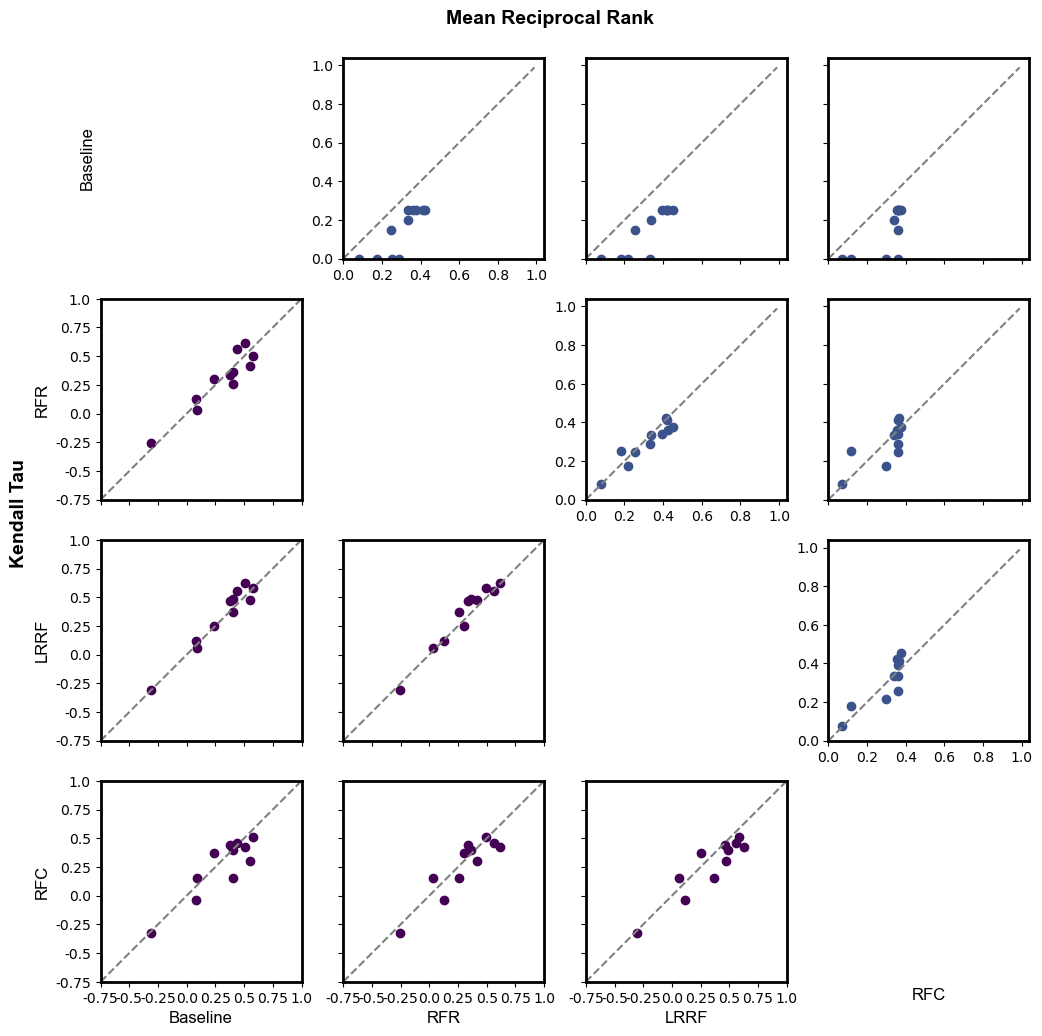

In [25]:
trellis_of_algs(
        cat_dicts[1],
        ["Baseline", "RFR", "LRRF", "RFC"],
        "kendall_tau",
        "mean_reciprocal_rank",
        filename=None
    )

In [23]:
amine2_dicts = [{}, {}, {}, {}]
for k, v in amine6_dict.items():
    for i in range(4) :
        amine2_dicts[i].update({
            k:v.iloc[110*i:110*(i+1),:]
        })

for i in range(4):
    print(i)
    for k, v in amine2_dicts[i].items():
        print(k)
        print(round(v["kendall_tau"].mean(), 3))
        print(round(v["mean_reciprocal_rank"].mean(), 3))
    print("---------------------------")


0
RFR
0.326
0.448
Baseline
0.198
0.195
RPC
0.149
0.356
LRRF
0.156
0.392
RFC
0.18
0.358
LR
-0.047
0.243
KNN
0.108
0.409
---------------------------
1
RFR
0.402
0.463
Baseline
0.343
0.195
RPC
0.314
0.433
LRRF
0.293
0.439
RFC
0.299
0.382
LR
-0.08
0.208
KNN
0.15
0.435
---------------------------
2
RFR
0.273
0.487
Baseline
0.173
0.236
RPC
0.122
0.416
LRRF
0.159
0.437
RFC
0.167
0.389
LR
0.027
0.28
KNN
0.19
0.428
---------------------------
3
RFR
0.343
0.452
Baseline
0.313
0.245
RPC
0.322
0.4
LRRF
0.355
0.412
RFC
0.267
0.342
LR
-0.048
0.219
KNN
0.305
0.381
---------------------------


RFR
7.0
0.676

Baseline
5.0
0.735

RPC
10.4
0.537

LRRF
3.9
0.802

RFC
3.0
0.808

LR
19.2
0.357

KNN
3.4
0.816



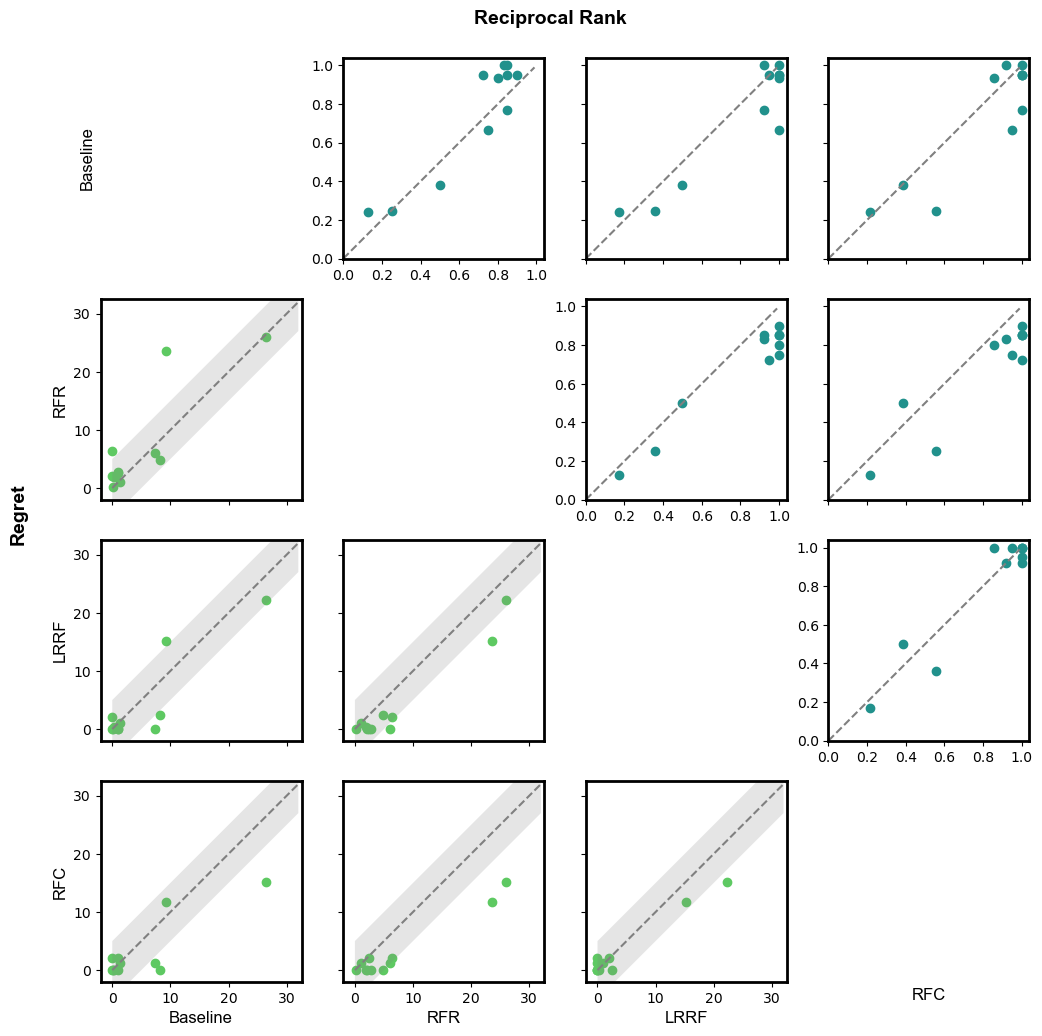

In [5]:
trellis_of_algs(
        amine2_dicts[0],
        ["Baseline", "RFR", "LRRF", "RFC"],
        "regret",
        "reciprocal_rank",
        filename=None
    )

### Looking at stability of models

/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **

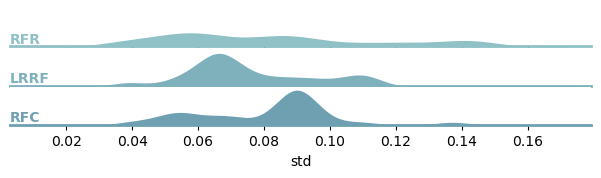

/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **

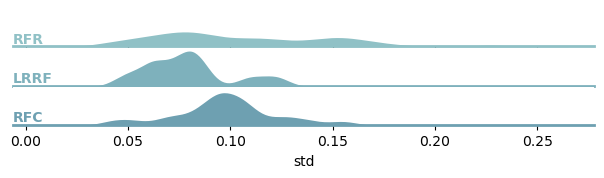

/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **

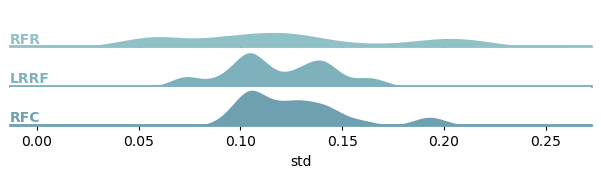

In [49]:
# amine2_dicts = [{}, {}, {}, {}]
# for k, v in amine6_dict.items():
#     for i in range(4) :
#         amine2_dicts[i].update({
#             k:v.iloc[110*i:110*(i+1),:]
#         })
# amine2_dfs = []
# std_by_model = {"model":[], "std":[]}
# for dict_obj in amine2_dicts :
#     for k, v in dict_obj.items():
#         if k in ["RFR", "LRRF", "RFC"] :
#             std_list = []
#             for i in range(11) :
#                 std_list.append(v.iloc[10*i:10*(i+1), -4].std())
#             std_by_model["std"].extend(std_list)
#             std_by_model["model"].extend([k]*len(std_list))
for a in [cat4_dict, cat8_dict, cat12_dict]:
    cat_dicts = [{}, {}]
    for k, v in a.items():
        for i in range(2) :
            cat_dicts[i].update({
                k:v.iloc[110*i:110*(i+1),:]
            })
    cat_dfs = []
    std_by_model = {"model":[], "std":[]}
    for dict_obj in cat_dicts :
        for k, v in dict_obj.items():
            if k in ["RFR", "LRRF", "RFC"] :
                std_list = []
                for i in range(11) :
                    std_list.append(v.iloc[10*i:10*(i+1), -6].std()) # -6 : kendall tau, -4: MRR
                std_by_model["std"].extend(std_list)
                std_by_model["model"].extend([k]*len(std_list))
    df = pd.DataFrame(std_by_model)
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df, row="model", hue="model", aspect=15, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "std",
        bw_adjust=.5, clip_on=False,
        fill=True, alpha=1, linewidth=0.5)
    g.map(sns.kdeplot, "std", clip_on=False, color="w", lw=2, bw_adjust=.5)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)


    g.map(label, "std")

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=.05)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    plt.show()

## NatureHTE dataset analysis

In [19]:
sulfon_dict1 = prep_performance_by_model_dict("performance_excels/natureHTE/fp_sulfonamide_None_rem1rxns.xlsx")
sulfon_dict2 = prep_performance_by_model_dict("performance_excels/natureHTE/fp_sulfonamide_None_rem2rxns.xlsx")
amide_dict1 = prep_performance_by_model_dict("performance_excels/natureHTE/fp_amide_None_rem1rxns.xlsx")
amide_dict2 = prep_performance_by_model_dict("performance_excels/natureHTE/fp_amide_None_rem2rxns.xlsx")
amine_dict1 = prep_performance_by_model_dict("performance_excels/natureHTE/fp_amine_None_rem1rxns.xlsx")
amine_dict2 = prep_performance_by_model_dict("performance_excels/natureHTE/fp_amine_None_rem2rxns.xlsx")

In [20]:
for k, v in sulfon_dict2.items():
    print(k)
    # print(round(v["regret"].mean(), 1))
    print(round(v["reciprocal_rank"].mean(), 3))
    print()

RFR
0.632

Baseline
0.642

RPC
0.614

LRRF
0.646

RFC
0.617

LR
0.548

KNN
0.575



In [21]:
for k, v in amide_dict2.items():
    print(k)
    print(round(v["regret"].mean(), 1))
    print(round(v["reciprocal_rank"].mean(), 3))
    print()

RFR
14.3
0.618

Baseline
14.7
0.513

RPC
15.0
0.578

LRRF
12.6
0.584

RFC
13.4
0.595

LR
13.4
0.575

KNN
12.0
0.617



In [22]:
for k, v in amine_dict2.items():
    print(k)
    # print(round(v["regret"].mean(), 1))
    print(round(v["reciprocal_rank"].mean(), 3))
    print()

RFR
0.625

Baseline
0.601

RPC
0.605

LRRF
0.584

RFC
0.576

LR
0.568

KNN
0.595



RFR
13.9
0.646

Baseline
13.1
0.606

RPC
22.3
0.627

LRRF
18.9
0.622

RFC
18.0
0.633

LR
20.4
0.619

KNN
21.1
0.624



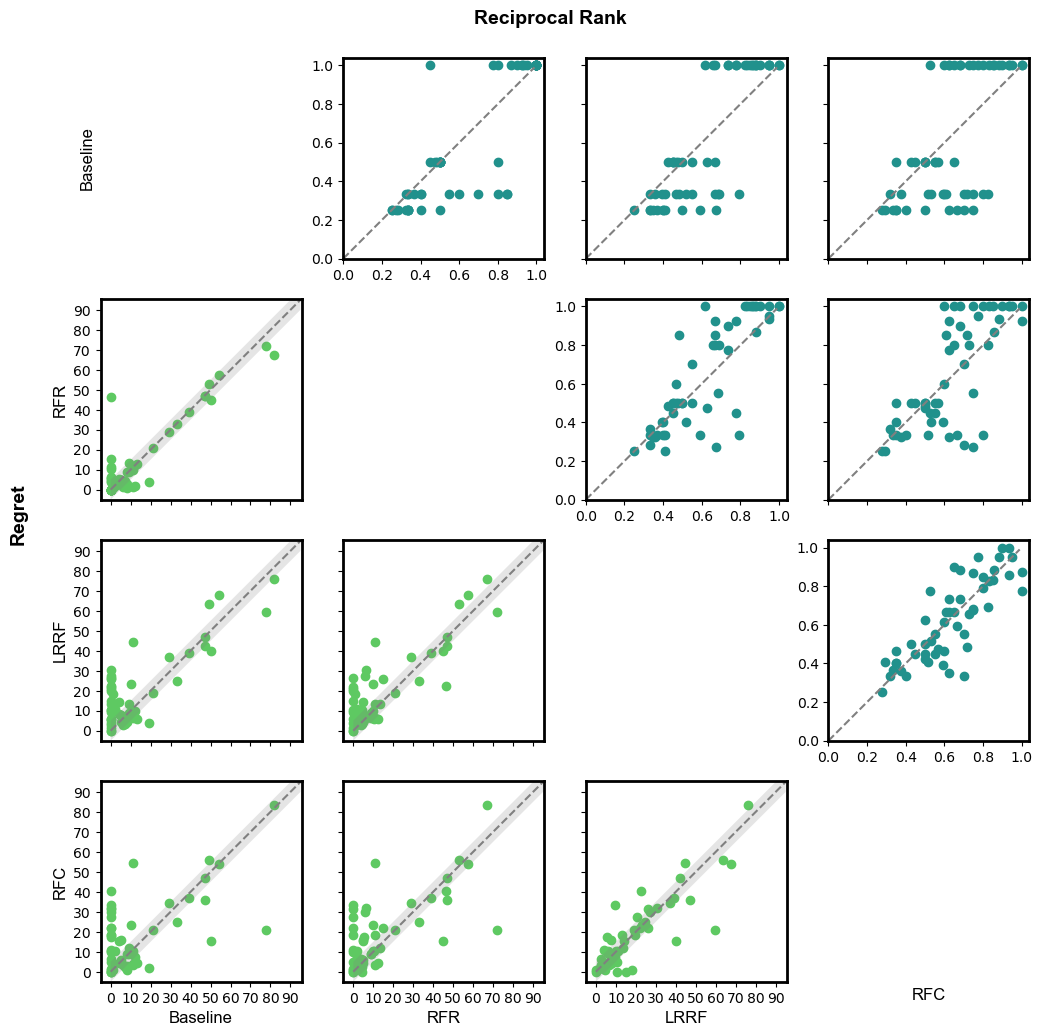

In [38]:
for k, v in amine_dict1.items():
    print(k)
    print(round(v["regret"].mean(), 1))
    print(round(v["reciprocal_rank"].mean(), 3))
    print()

trellis_of_algs(
        amine_dict1,
        ["Baseline", "RFR", "LRRF", "RFC"],
        "regret",
        "reciprocal_rank",
        filename=None
    )

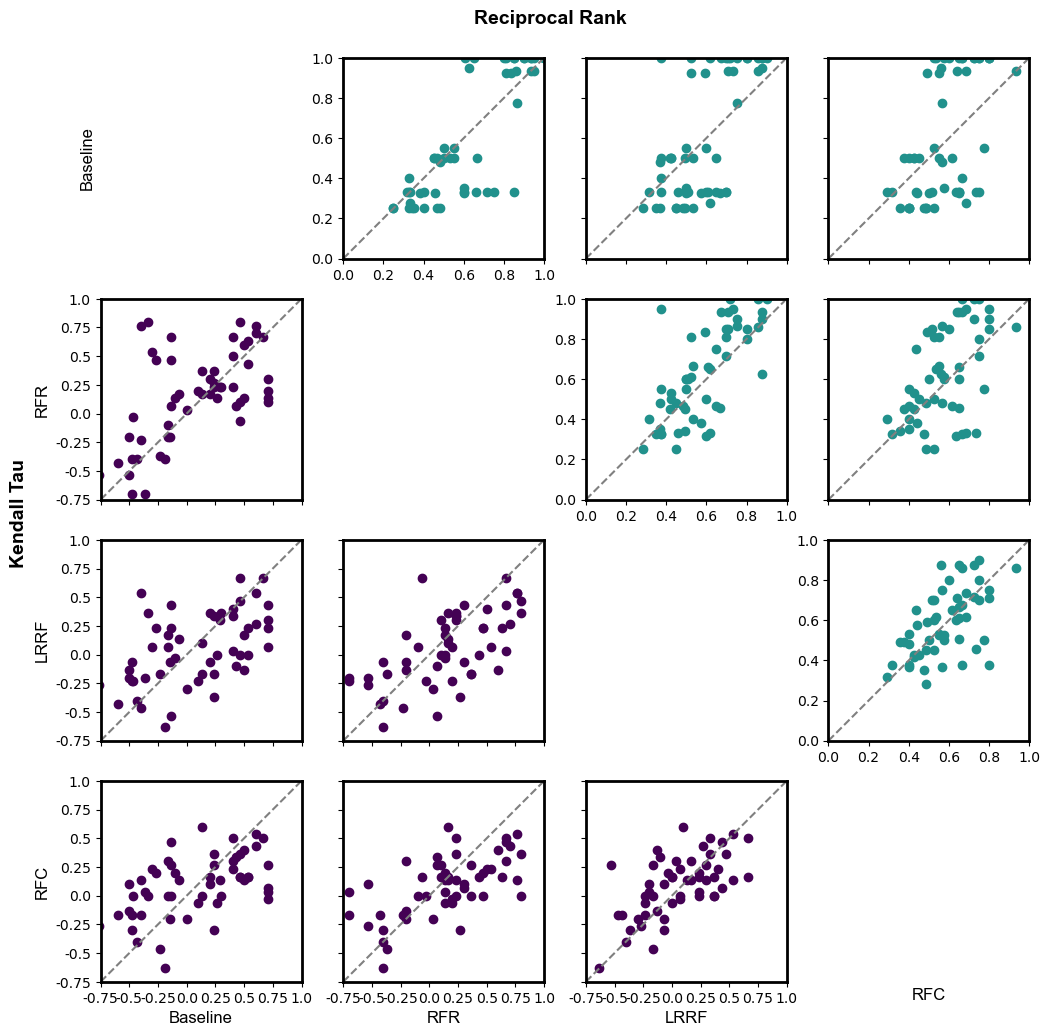

In [93]:
trellis_of_algs(
        amine_dict,
        ["Baseline", "RFR", "LRRF", "RFC"],
        "kendall_tau",
        "reciprocal_rank",
        filename=None
    )